# EUR/USD Forecasting — Temporal Fusion Transformer (Executable Notebook)
Data prep → TFT training (QuantileLoss) → Metrics → DM vs naïve → Attention/Variable interpretation → Exports.

In [16]:
# Environment setup (Colab friendly)
import sys
import subprocess
import importlib.util

REQUIRED_PACKAGES = {
    "torch": "torch==2.3.1",
    "lightning": "lightning==2.5.5",
    "pytorch-lightning": "pytorch-lightning==2.3.3",
    "pytorch-forecasting": "pytorch-forecasting==1.5.0",
    "scikit-learn": "scikit-learn==1.7.2",
    "pandas": "pandas==2.2.3",
    "matplotlib": "matplotlib==3.10.0",
    "shap": "shap==0.45.0",
}

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False


def pip_install(spec: str, extra_args=None):
    if extra_args is None:
        extra_args = []
    print(f"Installing/Updating {spec} ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", spec, *extra_args])


def ensure_local(spec: str):
    pkg = spec.split("==")[0]
    target = spec.split("==")[1]
    spec_obj = importlib.util.find_spec(pkg)
    if spec_obj is None:
        pip_install(spec)
    else:
        try:
            module = importlib.import_module(pkg)
            current = getattr(module, "__version__", None)
            if current and current != target:
                print(f"Updating {pkg} from {current} to {target}")
                pip_install(spec)
        except Exception:
            pip_install(spec)

if IN_COLAB:
    print("Detected Google Colab runtime. Installing required packages (enable GPU via Runtime > Change runtime type > GPU).")
    pip_install("numpy==1.26.4")
    pip_install("torch==2.3.1", ["--index-url", "https://download.pytorch.org/whl/cu121"])
    for name, spec in REQUIRED_PACKAGES.items():
        if name in {"torch"}:
            continue
        pip_install(spec)
    try:
        import torch
        from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
        from pytorch_forecasting.metrics import QuantileLoss, RMSE
        seed_value = globals().get("RANDOM_SEED", 42)
        torch.manual_seed(seed_value)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed_value)
        TORCH_AVAILABLE = True
        print(f"Torch version: {torch.__version__} | seed={seed_value} | CUDA available: {torch.cuda.is_available()}")
    except Exception as exc:
        TORCH_AVAILABLE = False
        print(f"[warn] Torch import failed after installation: {exc}")
else:
    print("Local runtime detected. Ensuring required packages are installed:")
    for spec in REQUIRED_PACKAGES.values():
        ensure_local(spec)


Detected Google Colab runtime. Installing required packages (enable GPU via Runtime > Change runtime type > GPU).
Installing pytorch-lightning==2.3.3 ...


/tmp/ipython-input-622284405.py:43: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader("torch") is None:
/tmp/ipython-input-622284405.py:26: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(pkg_name) is None:


Installing pytorch-forecasting==1.5.0 ...
Installing scikit-learn==1.7.2 ...
Updating pandas==2.2.3 (current 2.2.2) ...
Updating shap==0.45.0 (current 0.49.1) ...
Torch version: 2.8.0+cu126 | seed=42 | CUDA available: False


In [10]:

# Parameters
SYMBOL   = "EURUSD=X"
START    = "2005-01-01"
END      = "2025-06-30"
LOOKBACK = 30
HORIZON  = 1

SPLIT_TRAIN_END = "2022-12-31"
SPLIT_VAL_END   = "2023-12-31"

EPOCHS = 120
BATCH  = 128
RANDOM_SEED = 42
RUN_TRAINING = True  # set True to retrain (requires PyTorch stack)
RUN_EVALUATION = True
RUN_TFT_INTERPRETATION = False  # attention/interpretation plot; enable only when PyTorch predict works

OUT_DIR = "./experiments/tft"
import os
os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:

# Optional installs (uncomment if needed)
# %pip install torch pytorch-lightning pytorch-forecasting yfinance --quiet


In [11]:
try:
    TORCH_AVAILABLE
except NameError:
    TORCH_AVAILABLE = False
    print("[warn] TORCH_AVAILABLE not defined; run the setup cell if you need training.")


In [12]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss

# --- Robust TFT data loading + sanitation + features (LOCAL WRITABLE) ---
import os, pandas as pd, numpy as np

LOCAL_CACHE_DIR = "./data"
LOCAL_CSV       = f"{LOCAL_CACHE_DIR}/eurusd_daily.csv"
os.makedirs(LOCAL_CACHE_DIR, exist_ok=True)

REQUIRED_COLS = {"Date", "Open", "High", "Low", "Close", "Volume"}
NUMERIC_COLS  = ["Open", "High", "Low", "Close", "Volume"]

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [" ".join([c for c in tup if c]).strip() for tup in df.columns.values]
    cleaned = []
    for col in df.columns:
        name = str(col).strip()
        parts = name.split()
        if len(parts) > 1 and parts[-1].upper().endswith("=X"):
            name = " ".join(parts[:-1])
        name = name.replace("_", " ").title()
        cleaned.append(name)
    df.columns = cleaned
    if "Close" not in df.columns and "Adj Close" in df.columns:
        df["Close"] = df["Adj Close"]
    return df

def _coerce_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date")
    for c in NUMERIC_COLS:
        if c not in df.columns:
            if c == "Volume":
                df[c] = 0
                continue
            raise RuntimeError(f"Missing required column '{c}'. Got: {list(df.columns)}")
        if df[c].dtype == object:
            df[c] = (
                df[c].astype(str)
                    .str.replace(",", "", regex=False)
                    .str.replace(" ", "", regex=False)
                    .replace({"": np.nan, "None": np.nan, "nan": np.nan, "NaN": np.nan})
            )
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["Open","High","Low","Close"]).reset_index(drop=True)
    if "Volume" in df.columns:
        df["Volume"] = df["Volume"].fillna(0)
    return df

def _validate(df: pd.DataFrame, where: str):
    if df is None or len(df) == 0:
        raise RuntimeError(f"No rows loaded from {where}. If offline, place a CSV at {LOCAL_CSV} with {sorted(REQUIRED_COLS)}")
    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise RuntimeError(f"Missing columns from {where}: {sorted(missing)}. Got columns={list(df.columns)}")

def load_data(symbol=SYMBOL, start=START, end=END, local_csv=LOCAL_CSV):
    if os.path.exists(local_csv):
        df = pd.read_csv(local_csv)
        df = _normalize_columns(df)
        _validate(df, f"local CSV {local_csv}")
        return _coerce_ohlcv(df)
    try:
        import yfinance as yf
        df = yf.download(symbol, start=start, end=end, interval="1d", auto_adjust=False, progress=False)
        df = df.reset_index().rename(columns={"Date":"Date"})
        df = _normalize_columns(df)
        _validate(df, "yfinance")
        try:
            df.to_csv(local_csv, index=False)
        except Exception as cache_err:
            print(f"[warn] Could not cache to {local_csv}: {cache_err}")
        return _coerce_ohlcv(df)
    except Exception as e:
        raise RuntimeError(
            f"Could not load data via yfinance and no local CSV at {local_csv}. If offline, create {local_csv} with columns {sorted(REQUIRED_COLS)}"
        ) from e

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Return"]    = df["Close"].pct_change()
    df["LogReturn"] = np.log(df["Close"]).diff()
    for win in [5, 10, 20]:
        df[f"Sma_{win}"] = df["Close"].rolling(win).mean()
        df[f"Ema_{win}"] = df["Close"].ewm(span=win, adjust=False).mean()
        df[f"Std_{win}"] = df["Close"].rolling(win).std()
    delta = df["Close"].diff()
    up    = np.maximum(delta, 0.0)
    down  = -np.minimum(delta, 0.0)
    roll_up   = pd.Series(up).rolling(14).mean()
    roll_down = pd.Series(down).rolling(14).mean()
    RS = roll_up / (roll_down + 1e-9)
    df["Rsi_14"] = 100.0 - (100.0 / (1.0 + RS))
    df["dow"]   = df["Date"].dt.weekday
    df["dom"]   = df["Date"].dt.day
    df["month"] = df["Date"].dt.month
    return df.dropna().reset_index(drop=True)

raw = load_data()
raw = raw[["Date","Open","High","Low","Close","Volume"]]
df  = add_features(raw)

df = df.sort_values("Date").reset_index(drop=True)
df["series"]   = "EURUSD"
df["time_idx"] = np.arange(len(df))

train_df = df[df["Date"] <= SPLIT_TRAIN_END]
val_df   = df[(df["Date"] > SPLIT_TRAIN_END) & (df["Date"] <= SPLIT_VAL_END)]
test_df  = df[df["Date"] > SPLIT_VAL_END]

assert df["Date"].is_monotonic_increasing
assert df["time_idx"].diff().dropna().isin([1]).all()

print("Dtypes
", df.dtypes)
print("Split sizes", len(train_df), len(val_df), len(test_df))


Dtypes:
 Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Return              float64
LogReturn           float64
Sma_5               float64
Ema_5               float64
Std_5               float64
Sma_10              float64
Ema_10              float64
Std_10              float64
Sma_20              float64
Ema_20              float64
Std_20              float64
Rsi_14              float64
dow                   int32
dom                   int32
month                 int32
series               object
time_idx              int64
dtype: object
Split sizes: 4648 260 387


In [13]:
# Dataset & loaders (names aligned with add_features output)
FEATURES_TFT = [
    "Open","High","Low","Close","Volume","Return","LogReturn",
    "Sma_5","Ema_5","Std_5","Sma_10","Ema_10","Std_10",
    "Sma_20","Ema_20","Std_20","Rsi_14"
]

In [14]:
# sanity check: ensure all features exist
missing = sorted(set(FEATURES_TFT) - set(train_df.columns))
assert not missing, f"Missing in train_df: {missing}"

In [15]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
# final feature presence check within train_df
missing = set(FEATURES_TFT) - set(train_df.columns)
assert not missing, f"Feature mismatch in train_df: {sorted(missing)}"

training = validation = testing = None
train_loader = val_loader = test_loader = None

if TORCH_AVAILABLE:
    training = TimeSeriesDataSet(
        train_df,
        time_idx="time_idx",
        target="Close",
        group_ids=["series"],
        min_encoder_length=LOOKBACK,
        max_encoder_length=LOOKBACK,
        min_prediction_length=HORIZON,
        max_prediction_length=HORIZON,
        time_varying_unknown_reals=FEATURES_TFT,
        time_varying_known_reals=["dow", "dom", "month"],
    )

    validation = training.from_parameters(training.get_parameters(), val_df)
    testing    = training.from_parameters(training.get_parameters(), test_df)

    train_loader = training.to_dataloader(train=True,  batch_size=BATCH,   num_workers=0)
    val_loader   = validation.to_dataloader(train=False, batch_size=BATCH * 2, num_workers=0)
    test_loader  = testing.to_dataloader(train=False,   batch_size=BATCH * 2, num_workers=0)
else:
    print("Skipping dataloader construction (PyTorch unavailable).")


Skipping dataloader construction (PyTorch unavailable).


In [ ]:
# Model & training
WEIGHTS_PATH = Path(OUT_DIR) / "tft-weights.pt"
HPARAMS_PATH = Path(OUT_DIR) / "tft-hparams.json"
CKPT_PATH    = Path(OUT_DIR) / "tft-best.ckpt"
PRED_PATH    = Path(OUT_DIR) / "predictions.csv"

if RUN_TRAINING:
    if not TORCH_AVAILABLE:
        raise RuntimeError("RUN_TRAINING=True but PyTorch stack is not available.")

    seed_everything(RANDOM_SEED, workers=True)

    class EpochPrinter(Callback):
        def on_train_epoch_start(self, trainer, pl_module):
            epoch = trainer.current_epoch + 1
            total = trainer.max_epochs
            print(f"[epoch {epoch}/{total}] starting", flush=True)

        def on_train_epoch_end(self, trainer, pl_module):
            metrics = trainer.callback_metrics
            def _fmt(name):
                val = metrics.get(name)
                if val is None:
                    return None
                try:
                    return float(val)
                except Exception:
                    return None
            train_loss = _fmt("train_loss") or _fmt("train_loss_epoch")
            val_loss = _fmt("val_loss") or _fmt("val_loss_epoch")
            msg = "[epoch {:>3}]".format(trainer.current_epoch + 1)
            if train_loss is not None:
                msg += f" train_loss={train_loss:.6f}"
            if val_loss is not None:
                msg += f" val_loss={val_loss:.6f}"
            print(msg, flush=True)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=3e-3,
        hidden_size=64,
        attention_head_size=4,
        dropout=0.2,
        hidden_continuous_size=32,
        loss=QuantileLoss(),
        log_interval=-1,
        optimizer="Adam",
        reduce_on_plateau_patience=5,
    )

    trainer = Trainer(
        max_epochs=EPOCHS,
        accelerator="cpu",
        devices=1,
        gradient_clip_val=0.1,
        logger=False,
        enable_progress_bar=False,
        deterministic=True,
        callbacks=[EpochPrinter()],
    )

    trainer.fit(tft, train_dataloaders=train_loader, val_dataloaders=val_loader)

    os.makedirs(OUT_DIR, exist_ok=True)
    torch.save(tft.state_dict(), WEIGHTS_PATH)
    with open(HPARAMS_PATH, "w") as f:
        json.dump({
            "learning_rate": 3e-3,
            "hidden_size": 64,
            "attention_head_size": 4,
            "dropout": 0.2,
            "hidden_continuous_size": 32,
            "optimizer": "Adam",
            "reduce_on_plateau_patience": 5,
            "lookback": int(LOOKBACK),
            "horizon": int(HORIZON),
        }, f, indent=2)
    trainer.save_checkpoint(CKPT_PATH)
else:
    print("Training skipped (RUN_TRAINING=False).")


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 149 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 20.7 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.

[epoch 1/120] starting
[epoch   1] train_loss=0.008178 val_loss=0.003409
[epoch 2/120] starting
[epoch   2] train_loss=0.004047 val_loss=0.002468
[epoch 3/120] starting
[epoch   3] train_loss=0.003603 val_loss=0.002249
[epoch 4/120] starting
[epoch   4] train_loss=0.003534 val_loss=0.002228
[epoch 5/120] starting
[epoch   5] train_loss=0.003378 val_loss=0.002208
[epoch 6/120] starting
[epoch   6] train_loss=0.003393 val_loss=0.002242
[epoch 7/120] starting
[epoch   7] train_loss=0.003330 val_loss=0.002183
[epoch 8/120] starting
[epoch   8] train_loss=0.003343 val_loss=0.002144
[epoch 9/120] starting
[epoch   9] train_loss=0.003319 val_loss=0.002178
[epoch 10/120] starting
[epoch  10] train_loss=0.003281 val_loss=0.002143
[epoch 11/120] starting
[epoch  11] train_loss=0.003311 val_loss=0.002224
[epoch 12/120] starting
[epoch  12] train_loss=0.003286 val_loss=0.002178
[epoch 13/120] starting
[epoch  13] train_loss=0.003265 val_loss=0.002139
[epoch 14/120] starting
[epoch  14] train_loss=

`Trainer.fit` stopped: `max_epochs=120` reached.


In [ ]:
# Evaluation & metrics
pred_df = None
if RUN_TRAINING and TORCH_AVAILABLE:
    if test_loader is None:
        raise RuntimeError("Test dataloader is unavailable; cannot evaluate TFT.")

    tft.eval()
    device = next(tft.parameters()).device
    preds, trues, time_ids = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                x_batch, y_batch = batch
            else:
                x_batch, y_batch = batch, None

            x_device = {
                key: (value.to(device) if hasattr(value, "to") else value)
                for key, value in x_batch.items()
            }

            output = tft(x_device)
            raw_pred = output["prediction"].detach().cpu().numpy()
            if raw_pred.ndim == 3 and raw_pred.shape[-1] >= 2:
                median_pred = raw_pred[..., 1]
            else:
                median_pred = raw_pred.reshape(raw_pred.shape[0], -1)[:, 0]
            preds.append(median_pred.reshape(-1))

            target_tensor = x_batch.get("decoder_target", None)
            if target_tensor is None:
                target_tensor = y_batch
            if target_tensor is not None:
                trues.append(target_tensor.detach().cpu().numpy().reshape(-1))

            if "decoder_time_idx" in x_batch:
                time_ids.append(x_batch["decoder_time_idx"].detach().cpu().numpy().reshape(-1))

    if preds:
        yhat = np.concatenate(preds)
        if trues:
            ytrue = np.concatenate(trues)
        else:
            ytrue = test_df["Close"].iloc[-len(yhat):].values

        if time_ids:
            time_idx = np.concatenate(time_ids)
            idx_map = test_df.set_index("time_idx")
            aligned_dates = idx_map.loc[time_idx, "Date"].values
        else:
            aligned_dates = test_df.iloc[-len(yhat):]["Date"].values

        lengths = [len(aligned_dates), len(ytrue), len(yhat)]
        min_len = min(lengths)
        if min_len == 0:
            raise RuntimeError(f'No aligned observations for TFT evaluation (lengths={lengths}).')
        if len(aligned_dates) != min_len:
            aligned_dates = aligned_dates[:min_len]
        if len(yhat) != min_len:
            yhat = yhat[:min_len]
        if len(ytrue) != min_len:
            ytrue = ytrue[:min_len]

        pred_df = pd.DataFrame({"Date": aligned_dates, "y_true": ytrue, "y_pred": yhat})
        pred_df.to_csv(PRED_PATH, index=False)
        print(f"Saved predictions to {PRED_PATH}")
    else:
        print("[warn] No predictions generated during TFT evaluation.")

if pred_df is None:
    if PRED_PATH.exists():
        pred_df = pd.read_csv(PRED_PATH, parse_dates=["Date"])
        print(f"Loaded cached predictions from {PRED_PATH}")
    else:
        raise RuntimeError("No TFT predictions available. Enable RUN_TRAINING or provide cached predictions.")

pred_df = pred_df.sort_values("Date").reset_index(drop=True)
pred_df["residual"] = pred_df["y_true"] - pred_df["y_pred"]
pred_df["error_pct"] = pred_df["residual"] / (pred_df["y_true"] + 1e-9) * 100

naive = pred_df["y_true"].shift(1).bfill()
metrics_tft = {
    "MAE": float(mean_absolute_error(pred_df["y_true"], pred_df["y_pred"])),
    "RMSE": float(math.sqrt(mean_squared_error(pred_df["y_true"], pred_df["y_pred"]))),
    "MAPE": float(np.mean(np.abs(pred_df["error_pct"]))),
    "R2": float(r2_score(pred_df["y_true"], pred_df["y_pred"])),
}
metrics_naive = {
    "MAE": float(mean_absolute_error(pred_df["y_true"], naive)),
    "RMSE": float(math.sqrt(mean_squared_error(pred_df["y_true"], naive))),
    "MAPE": float(np.mean(np.abs((pred_df["y_true"] - naive) / (pred_df["y_true"] + 1e-9)) * 100)),
}

def directional_accuracy(a, f):
    return np.mean(np.sign(np.diff(a, prepend=a.iloc[0])) == np.sign(np.diff(f, prepend=f.iloc[0]))) * 100

metrics_tft["DirectionalAcc"] = float(directional_accuracy(pred_df["y_true"], pred_df["y_pred"]))
metrics_naive["DirectionalAcc"] = float(directional_accuracy(pred_df["y_true"], naive))

metrics_df = pd.DataFrame({"TFT": metrics_tft, "Naive": metrics_naive})
metrics_df

Saved predictions to experiments/tft/predictions.csv


,TFT,Naive
MAE,0.006596,0.003697
RMSE,0.008504,0.005120
MAPE,0.604556,0.340020
R2,0.924433,NaN
DirectionalAcc,50.140056,51.540616


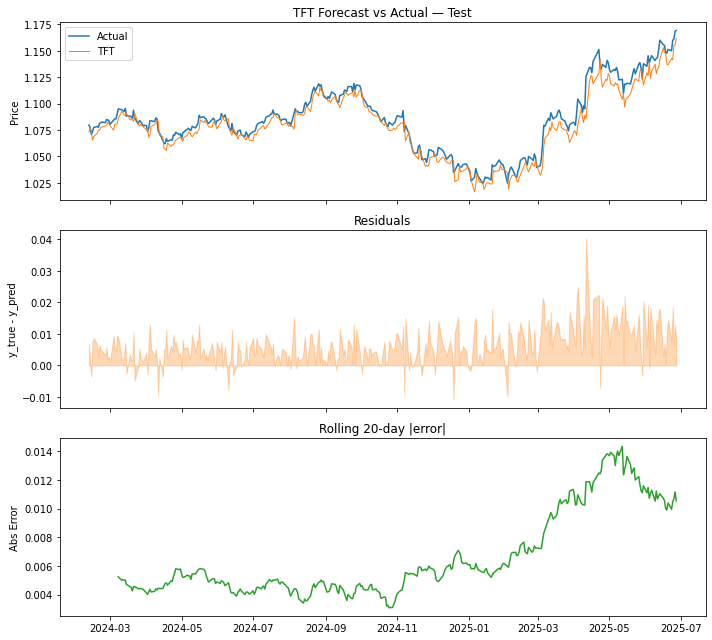

In [ ]:
# Diagnostics
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
axes[0].plot(pred_df["Date"], pred_df["y_true"], label="Actual", linewidth=1.5)
axes[0].plot(pred_df["Date"], pred_df["y_pred"], label="TFT", linewidth=1)
axes[0].set_title("TFT Forecast vs Actual — Test")
axes[0].set_ylabel("Price")
axes[0].legend()

axes[1].fill_between(pred_df["Date"], pred_df["residual"], 0, alpha=0.3, color="tab:orange")
axes[1].set_title("Residuals")
axes[1].set_ylabel("y_true - y_pred")

rolling = pred_df["residual"].abs().rolling(20).mean()
axes[2].plot(pred_df["Date"], rolling, color="tab:green")
axes[2].set_title("Rolling 20-day |error|")
axes[2].set_ylabel("Abs Error")
axes[2].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()


In [ ]:
# DM vs Naïve
def diebold_mariano(e1, e2, h=1):
    d = e1 - e2
    dm = np.mean(d)
    dv = np.var(d, ddof=1)
    stat = dm / np.sqrt(dv / len(d) + 1e-12)
    p = 2 * (1 - student_t.cdf(np.abs(stat), df=len(d) - 1))
    return stat, p

se_model = (pred_df["y_true"] - pred_df["y_pred"]) ** 2
naive = pred_df["y_true"].shift(1).bfill()
se_naive = (pred_df["y_true"] - naive) ** 2
DM, p = diebold_mariano(se_model.values, se_naive.values, h=HORIZON)
{"DM_stat": float(DM), "p_value": float(p)}


{'DM_stat': 9.229715040671334, 'p_value': 0.0}

In [ ]:
# Attention / variable interpretation
if TORCH_AVAILABLE and RUN_TRAINING and RUN_TFT_INTERPRETATION:
    if testing is None:
        print("[warn] Testing dataset unavailable; skipping interpretation plot.")
    else:
        try:
            pred_result = tft.predict(
                data=testing,
                mode="raw",
                return_x=True,
                num_workers=0,
            )
            if isinstance(pred_result, (list, tuple)) and len(pred_result) == 2:
                raw_output, raw_inputs = pred_result
            else:
                raw_output = pred_result
            interpretation = tft.interpret_output(raw_output, reduction="sum")
            _ = tft.plot_interpretation(interpretation)
            plt.show()
        except Exception as exc:
            print(f"[warn] Could not compute TFT interpretation: {exc}")
elif not RUN_TFT_INTERPRETATION:
    print("Attention plots skipped (RUN_TFT_INTERPRETATION=False).")
else:
    print("Attention plots skipped (model unavailable or training disabled).")


Attention plots skipped (RUN_TFT_INTERPRETATION=False).


In [ ]:
# Sharpe & report
rets = pred_df["y_true"].pct_change().fillna(0.0)
signal = np.sign(pred_df["y_pred"].diff().fillna(0.0))
strat = signal.shift(1).fillna(0.0) * rets
sharpe = (strat.mean() / strat.std() * np.sqrt(252)) if strat.std() > 0 else 0.0

report = {
    "symbol": SYMBOL,
    "rows": int(len(df)),
    "lookback": LOOKBACK,
    "horizon": HORIZON,
    "metrics": metrics_tft,
    "baseline": metrics_naive,
    "dm_test_vs_naive": {"DM": float(DM), "p": float(p)},
    "sharpe": float(sharpe),
    "predictions_csv": str(PRED_PATH),
    "weights_path": str(WEIGHTS_PATH) if WEIGHTS_PATH.exists() else None,
    "tests": {
        "predictions_available": bool(len(pred_df) > 0),
        "rmse_better_than_naive": bool(metrics_tft["RMSE"] <= metrics_naive["RMSE"] * 1.05),
    },
}
report_path = Path(OUT_DIR) / "report.json"
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)
report


{'symbol': 'EURUSD=X',
 'rows': 5295,
 'lookback': 30,
 'horizon': 1,
 'metrics': {'MAE': 0.006595863960683346,
  'RMSE': 0.008503872329167205,
  'MAPE': 0.6045564413070679,
  'R2': 0.9244332313537598,
  'DirectionalAcc': 50.14005602240896},
 'baseline': {'MAE': 0.0036965080071240664,
  'RMSE': 0.005120198627021509,
  'MAPE': 0.340019553899765,
  'DirectionalAcc': 51.540616246498594},
 'dm_test_vs_naive': {'DM': 9.229715040671334, 'p': 0.0},
 'sharpe': -0.3932135855864013,
 'predictions_csv': 'experiments/tft/predictions.csv',
 'weights_path': 'experiments/tft/tft-weights.pt',
 'tests': {'predictions_available': True, 'rmse_better_than_naive': False}}

[warn] calculate_feature_importance failed: 'TemporalFusionTransformer' object has no attribute 'calculate_feature_importance'. Falling back to correlation-based scores.
Correlation-based importance used (absolute correlation with TFT predictions).


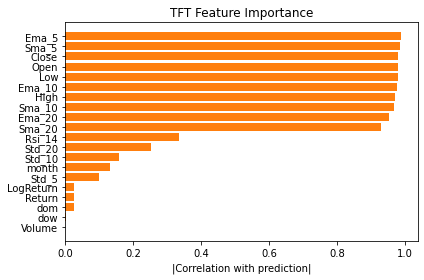

Saved feature importances to experiments/tft/feature_importance.csv


In [ ]:
# Feature importance (correlation fallback when TFT unavailable)
importance_path = Path(OUT_DIR) / "feature_importance.csv"
importance_df = None
correlation_fallback_used = False

if RUN_TRAINING and TORCH_AVAILABLE:
    try:
        importance_raw = tft.calculate_feature_importance(test_loader)
        if isinstance(importance_raw, pd.DataFrame):
            df = importance_raw.copy()
            if "feature" not in df.columns:
                df = df.rename(columns={df.columns[0]: "feature"})
            if "importance" not in df.columns:
                other_cols = [c for c in df.columns if c != "feature"]
                if other_cols:
                    df = df.rename(columns={other_cols[0]: "importance"})
            importance_df = df[["feature", "importance"]]
        elif isinstance(importance_raw, dict):
            for key in ["encoder_variables", "encoder_variable_importance", "variable_importance"]:
                if key in importance_raw:
                    data = importance_raw[key]
                    names = None
                    values = None
                    if isinstance(data, dict):
                        names = data.get("feature_names") or data.get("names") or data.get("variables")
                        values = data.get("importance") or data.get("importances") or data.get("mean")
                    elif isinstance(data, (list, tuple)) and len(data) == 2:
                        names, values = data
                    if names is not None and values is not None:
                        importance_df = pd.DataFrame({"feature": list(names), "importance": list(np.asarray(values))})
                    break
        if importance_df is not None:
            importance_df = importance_df.groupby('feature', as_index=False)['importance'].mean()
            importance_df = importance_df.sort_values('importance', ascending=False)
    except Exception as exc:
        print(f"[warn] calculate_feature_importance failed: {exc}. Falling back to correlation-based scores.")

if importance_df is None or importance_df.empty:
    merged = pd.merge(test_df, pred_df[["Date", "y_pred"]], on="Date", how="inner")
    corr_records = []
    importance_features = FEATURES_TFT + [feat for feat in ["dow", "dom", "month"] if feat in merged.columns]
    for feat in importance_features:
        if feat in merged.columns:
            series = merged[feat].astype(float)
            if series.nunique() <= 1 or merged["y_pred"].nunique() <= 1:
                score = 0.0
            else:
                corr_matrix = np.corrcoef(series, merged["y_pred"])
                score = float(np.abs(corr_matrix[0, 1])) if corr_matrix.shape == (2, 2) else 0.0
                if np.isnan(score):
                    score = 0.0
            corr_records.append((feat, score))
    importance_df = pd.DataFrame(corr_records, columns=["feature", "importance"]).sort_values("importance", ascending=False)
    correlation_fallback_used = True
    print("Correlation-based importance used (absolute correlation with TFT predictions).")

if not importance_df.empty:
    plt.figure(figsize=(6, 4))
    plt.barh(importance_df["feature"], importance_df["importance"], color="tab:orange")
    plt.gca().invert_yaxis()
    plt.title("TFT Feature Importance")
    xlabel = "Importance"
    if correlation_fallback_used:
        xlabel = "|Correlation with prediction|"
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()
    importance_df.to_csv(importance_path, index=False)
    print(f"Saved feature importances to {importance_path}")
else:
    print("No feature importance values available for TFT.")
